In [ ]:
!pip install tensorflow_addons -q
!pip install git+https://github.com/rcmalli/keras-vggface.git -q
!pip install kapre==0.1.7 -q
!pip install keras -q
!pip install keras_applications -q
!pip install opensmile -q
!pip install torch -q

In [ ]:
!git clone https://github.com/ErmachenkoBoris/lieDetector.git

fatal: destination path 'lieDetector' already exists and is not an empty directory.


In [ ]:
import sys
sys.path.append('/content/lieDetector')

In [ ]:
import os
import csv
import numpy as np
import librosa as lb
import librosa
import opensmile
import tensorflow as tf
import torch
import torchvision
import cv2
import math
import cv2
import numpy as np
import opensmile
import resampy
import tensorflow as tf
from kapre.time_frequency import Melspectrogram
from keras import Model
from keras_vggface import VGGFace

from dataset.tf_example_writer import TfExampleWriter
from utils.dirs import create_dirs
from random import shuffle
from numbers import Real

import cv2
import numpy as np
import opensmile
import resampy
import random

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


# Конфигурация

In [ ]:
import torch

device = torch.device('cuda:0')

In [ ]:
from enum import Enum
import tensorflow as tf
from abc import ABC


class TimeDependentModality(ABC):
    WINDOW_STEP_IN_SECS = 1
    WINDOW_WIDTH_IN_SECS = 5


class VideoModalityConfig(TimeDependentModality):
    def __init__(self):
        super().__init__()
        self.FRAMES_PERIOD = 5
        self.SHAPE = 224
        self.FPS = 32
        self.FILE_EXT = '.mp4'


class PulseConfig(TimeDependentModality):
    def __init__(self):
        super().__init__()
        self.FPS = 50
        self.SHAPE = 224
        self.FILE_EXT = '.mp4'


class VideoSceneModalityConfig(VideoModalityConfig):
    def __init__(self):
        super().__init__()
        self.FILE_EXT = '.mp4'


class AudioModalityConfig(TimeDependentModality):
    def __init__(self):
        super().__init__()
        self.SR = 48000
        self.FILE_EXT = '.wav'


class Modality(Enum):
    def __new__(cls, *args, **kwds):
        value = len(cls.__members__) + 1
        obj = object.__new__(cls)
        obj._value_ = value
        return obj

    def __init__(self, config):
        self.config = config

    AUDIO = AudioModalityConfig()
    VIDEO_FACE = VideoModalityConfig()
    VIDEO_SCENE = VideoSceneModalityConfig()
    PULSE = PulseConfig()

In [ ]:
PRETRAINED_MODELS = "/content/drive/MyDrive/pretrained/"

In [ ]:
class ByteEncoder:
    def transform(self, feature):
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[feature]))


class IntEncoder:
    def transform(self, feature):
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[feature]))


class TensorEncoder(ByteEncoder):
    def transform(self, feature):
        feature = tf.io.serialize_tensor(tf.constant(feature)).numpy()
        return super().transform(feature)


class FeaturesSetConfig:
    def __init__(self, shape, input_shape=None):
        self.shape = shape
        self.input_shape = input_shape if input_shape is not None else shape


class DatasetFeaturesSet(Enum):
    def __new__(cls, *args, **kwds):
        value = len(cls.__members__) + 1
        obj = object.__new__(cls)
        obj._value_ = value
        return obj

    def __init__(self, encoder, config):
        self.encoder = encoder
        self.config = config

    OPENSMILE_ComParE_2016 = TensorEncoder(), FeaturesSetConfig(shape=(10, 6373), input_shape=(10, 6373))
    AUDIO = TensorEncoder(), FeaturesSetConfig(shape=(10, 512), input_shape=(10, 512))
    VIDEO_FACE = TensorEncoder(), FeaturesSetConfig(shape=0)
    VIDEO_SCENE = TensorEncoder(), FeaturesSetConfig(shape=0)
    PULSE = TensorEncoder(), FeaturesSetConfig(shape=(33, 512))
    CLASS = TensorEncoder(), FeaturesSetConfig(shape=7)
    VIDEO_FACE_R2PLUS1_FEATURES = TensorEncoder(), FeaturesSetConfig(shape=(33, 512))
    VIDEO_SCENE_R2PLUS1_FEATURES = TensorEncoder(), FeaturesSetConfig(shape=(33, 512))


# Модели

In [ ]:
def get_r2_plus_1_model(base_path):
    return torchvision.models.video.r2plus1d_18(pretrained=True).to(device)

def get_l3_model(base_path):
    model = tf.keras.models.load_model(base_path + "/openl3_audio_mel256_env.h5", custom_objects={
        'Melspectrogram': Melspectrogram}, compile=False)

    output = model.get_layer('activation_7').output
    output = tf.keras.layers.GlobalAveragePooling2D()(output)
    intermediate_layer_model = Model(inputs=model.input, outputs=output)
    return intermediate_layer_model

def get_vgg_model():
    return tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

def get_vgg_face_model():
    return VGGFace(include_top=False, weights='vggface', input_shape=(224, 224, 3), pooling='avg')

# Утилиты для видео

In [ ]:
def open_video(filename: str, size=224) -> tuple:
    cap = cv2.VideoCapture(filename)
    if not cap.isOpened():
        print("[ERROR][TF RECORDS BUILDING][VIDEO FACE] It's impossible to open file '{}'".format(filename))
        cap.release()

        filename = os.path.splitext(filename)[0] + ".avi"
        cap = cv2.VideoCapture(filename)
        if not cap.isOpened():
            cap.release()
            print("[ERROR][TF RECORDS BUILDING][VIDEO FACE] It's impossible to open file '{}'".format(filename))
            filename = os.path.splitext(filename)[0] + ".mov"
            cap = cv2.VideoCapture(filename)
            if not cap.isOpened():
                cap.release()
                print("[ERROR][TF RECORDS BUILDING][VIDEO FACE] It's impossible to open file '{}'".format(filename))
                raise RuntimeError

    fps = cap.get(cv2.CAP_PROP_FPS)

    example_frames = []
    while cap.isOpened():
        read, frame = cap.read()
        if not read:
            break
        example_frames.append(cv2.resize(frame, (size, size)))

    cap.release()
    return example_frames, fps


def extract_frames_from_video_with_fps(frames: list, fps, example: str, offset: float, duration: float, modality):
    offset_frames_count = math.floor(fps * offset)
    extracted_frames_count = math.floor(fps * duration)

    source_frames_count = math.floor(modality.config.FPS * duration)
    if extracted_frames_count < source_frames_count:
        diff = (source_frames_count - extracted_frames_count)
        delta = math.floor(diff / 2)
        offset_frames_count = math.floor(max(0, offset_frames_count - delta))
        extracted_frames_count = math.floor(min(len(frames) - 1, extracted_frames_count + diff))

    example_frames_list = frames[offset_frames_count:offset_frames_count + extracted_frames_count]

    example_total_frames = len(example_frames_list)

    frames_period = math.ceil(example_total_frames / source_frames_count)
    period_res = source_frames_count - (math.ceil(example_total_frames / frames_period))

    print("[INFO][{}] video frames_period:={}, period_res:={}".format(example, frames_period, period_res))

    # to get N frames from the face we extract frames with period and then randomly add
    counter_1 = 0
    result_list = []
    for i in range(example_total_frames):
        if frames_period == 1 or i % frames_period == 0:
            result_list.append(example_frames_list[i])
        elif (i - frames_period // 2) % frames_period == 0 and counter_1 < period_res:
            counter_1 += 1
            result_list.append(example_frames_list[i])

    result_list_resized = []
    for frame in result_list:
        result_list_resized.append(cv2.resize(frame, (modality.config.SHAPE, modality.config.SHAPE)))

    if len(result_list_resized) != source_frames_count:
        delta = source_frames_count - len(result_list_resized)
        result_list_resized = np.pad(result_list_resized, ((0, delta), (0, 0), (0, 0), (0, 0)), 'constant')

    return np.asarray(result_list_resized)


# Извлечение признаков

In [ ]:
def extract_r2_plus1_features(model, frames) -> np.ndarray:
    model_input = np.array(list(map(r2_plus_1_preprocess, frames)))
    model_input = tf.signal.frame(model_input, 32, 4, axis=0).numpy()
    # (1, 8, 3, 112, 112) - >(1, 3, 8, 112, 112)
    model_input = np.transpose(model_input, (0, 2, 1, 3, 4)).astype(np.float32)

    features = np.array(list(map(lambda x: extract_from_net(model, x), model_input)))
    features = np.array(list(map(lambda x: np.squeeze(x), features)))
    return features

def extract_from_net(model, frames):
    frames = np.expand_dims(frames, 0)
    input_tensor = torch.Tensor(frames)
    input_tensor = input_tensor.to(device)
    name = "avgpool"
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    model.avgpool.register_forward_hook(get_activation(name))
    model(input_tensor)
    features = activation[name].cpu().numpy()
    return features


def r2_plus_1_preprocess(frame):
    resized = cv2.resize(frame, (112, 112))
    resized = np.transpose(resized, (2, 0, 1))
    return resized


def _preprocess_audio_batch(audio, sr, center=True, hop_size=0.5, TARGET_SR=48000):
    """Process audio into batch format suitable for input to embedding model """
    if audio.size == 0:
        raise RuntimeError('Got empty audio')

    # Check audio array dimension
    if audio.ndim > 2:
        raise RuntimeError('Audio array can only be be 1D or 2D')

    elif audio.ndim == 2:
        # Downmix if multichannel
        audio = np.mean(audio, axis=1)

    if not isinstance(sr, Real) or sr <= 0:
        raise RuntimeError('Invalid sample rate {}'.format(sr))

    if not isinstance(hop_size, Real) or hop_size <= 0:
        raise RuntimeError('Invalid hop size {}'.format(hop_size))

    if center not in (True, False):
        raise RuntimeError('Invalid center value {}'.format(center))

    # Resample if necessary
    if sr != TARGET_SR:
        audio = resampy.resample(audio, sr_orig=sr, sr_new=TARGET_SR, filter='kaiser_best')

    audio_len = audio.size
    frame_len = TARGET_SR
    hop_len = int(hop_size * TARGET_SR)

    if center:
        # Center audio
        audio = _center_audio(audio, frame_len)

    # Pad if necessary to ensure that we process all samples
    audio = _pad_audio(audio, frame_len, hop_len)

    # Split audio into frames, copied from librosa.util.frame
    n_frames = 1 + int((len(audio) - frame_len) / float(hop_len))
    x = np.lib.stride_tricks.as_strided(audio, shape=(frame_len, n_frames),
                                        strides=(audio.itemsize, audio.itemsize)).T

    # Add a channel dimension
    x = x.reshape((x.shape[0], 1, x.shape[-1]))
    return x



def _center_audio(audio, frame_len):
    """Center audio so that first sample will occur in the middle of the first frame"""
    return np.pad(audio, (int(frame_len / 2.0), 0), mode='constant', constant_values=0)


def _pad_audio(audio, frame_len, hop_len):
    """Pad audio if necessary so that all samples are processed"""
    audio_len = audio.size
    if audio_len < frame_len:
        pad_length = frame_len - audio_len
    else:
        pad_length = int(np.ceil((audio_len - frame_len) / float(hop_len))) * hop_len \
                     - (audio_len - frame_len)

    if pad_length > 0:
        audio = np.pad(audio, (0, pad_length), mode='constant', constant_values=0)

    return audio


def stand(x):
    return (x - np.mean(x) / np.std(x))


def _extract_opensmile_features(audio, sr, features_set):
    smile = opensmile.Smile(
        feature_set=features_set,
        feature_level=opensmile.FeatureLevel.Functionals,
    )

    return np.array(list(map(lambda x: stand(smile.process_signal(np.squeeze(x), sr)), audio)))


In [ ]:
def extract_l3_features(model, audio) -> np.ndarray:
    # model_input = _l3_preprocess_audio(audio, AudioModalityConfig().SR)
    return model.predict(audio)


def extract_vgg_face_features(model, frames) -> np.ndarray:
    return model.predict(frames)

def extract_vgg_features(model, frames) -> np.ndarray:
    features = model.predict(frames)
    return np.reshape(features, (features.shape[0], features.shape[1] * features.shape[2] * features.shape[3]))

## Face

In [ ]:
def _select_face(frame, face, max_face_w, max_face_h):
    # increase face window
    x = face[0]
    y = face[1]
    w = max_face_w
    h = max_face_h

    return frame[y:y + h, x:x + w]


def _process_face_on_frame(frame: np.ndarray, face_model):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_model.detectMultiScale(gray, 1.1, 4)

    if len(faces) == 1:
        face = faces[0]
        return face
    elif len(faces) > 1:
        face_size = 0
        current_face = faces[0]
        nearest_face = None
        for face in faces:
            current_face_size = current_face[2] * current_face[3]
            if current_face_size > face_size:
                face_size = current_face_size
                nearest_face = face
        return nearest_face
    else:
        return None

def extract_face(frames, model):
  last_face_coords = None
  frames_with_face = []
  face_coords = [ _process_face_on_frame(f, model) for f in frames]

  max_face_w, max_face_h = -1, -1
  for i, face_coord in enumerate(face_coords):
    if face_coord is not None and face_coord[2] > max_face_w:
      max_face_w = face_coord[2]
    if face_coord is not None and face_coord[3] > max_face_h:
      max_face_h = face_coord[3]
      
  for i, face_coord in enumerate(face_coords):
    if face_coord is None:
      if last_face_coords is not None:
        frames_with_face.append(cv2.resize(_select_face(frames[i], last_face_coords, max_face_w, max_face_h), (224, 224)))
      else:
        frames_with_face.append(cv2.resize(np.zeros(frames[i].shape), (224, 224)))
    else:
      frames_with_face.append(cv2.resize(_select_face(frames[i], face_coord, max_face_w, max_face_h), (224, 224)))
      last_face_coords = face_coord

  return np.asarray(frames_with_face).astype('float32')

In [ ]:
def extract_face_and_coords_dict(frames, model):
  last_face_coords = None
  frames_with_face = []
  face_coords = [ _process_face_on_frame(f, model) for f in frames]
  res = []
  last_face = None
  for i, face_coords in enumerate(face_coords):
    if face_coords is not None:
      res.append(face_coords)
      last_face = face_coords
    elif last_face is not None:
      res.append(last_face)
    else:
      res.append([0,0,frames[i].shape[0], frames[i].shape[1]])

  return np.asarray(frames), np.asarray(res)

## Pulse

In [ ]:
from utils.pulse_detection.processors_noopenmdao import findFaceGetPulse

class PulseDetector():
    flagTest = True
    var = 0
    mean = 0


    def __init__(self):
        self.processor = findFaceGetPulse(bpm_limits=[50, 180],
                                          data_spike_limit=2500.,
                                          face_detector_smoothness=10.0)


    def toggle_search(self):
        """
        Toggles a motion lock on the processor's face detection component.
        Locking the forehead location in place significantly improves
        data quality, once a forehead has been sucessfully isolated.
        """
        state = self.processor.find_faces_toggle()

    def main_loop(self, i, frame, coords):
    
        """
        Single iteration of the application's main loop.
        """
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        _,thresh = cv2.threshold(img,10,255,cv2.THRESH_BINARY)
        contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        if (len(contours) == 0): 
          return
        cnt = contours[0]
        x,y,w,h = cv2.boundingRect(cnt)
        offset_y = 0
        offset_x = 0
        self.h, self.w, _c = frame.shape

        # set current image frame to the processor's input
        self.processor.frame_in = frame
        self.processor.coords = [coords]
#         # process the image frame to perform all needed analysis
        self.processor.run('')
#         # collect the output frame for display
        output_frame = self.processor.frame_out
        
        if self.flagTest is True and i > 10:
            self.toggle_search()
            self.flagTest = False
        
        if (i % 80 == 0 or i % 81 == 0) and i > 10:
            self.toggle_search()
            self.flagTest = False
        self.var = np.var(self.processor.bpms)
        self.mean = np.mean(self.processor.bpms)


def get_pulse(frames, coords):
    frames = tf.signal.frame(frames, 25, 1, axis=0).numpy()
    coords = tf.signal.frame(coords, 25, 1, axis=0).numpy()

    result = []
    for i in range(len(frames)):
      result.append(get_pulse_from_window(frames[i], coords[i]))
    return np.array(result)


def get_pulse_from_window(frames, coords):
  pulse_detector = PulseDetector()
  for i, frame in enumerate(frames):
    pulse_detector.main_loop(i, frame, coords[i])
  res = np.asarray([pulse_detector.var, pulse_detector.mean]).astype(np.float32)
  del pulse_detector
  return res

# Обработка

In [ ]:
WINDOW_LEN_IN_SEC = 10
STEP_LEN_IN_SEC = 1

In [ ]:
r2_plus_1_model = get_r2_plus_1_model(PRETRAINED_MODELS)

with tf.device('/device:GPU:0'):
  l3_model = get_l3_model(PRETRAINED_MODELS)
  vgg_model = get_vgg_model()
  vgg_face_model = get_vgg_face_model()

face_model = cv2.CascadeClassifier('/content/lieDetector/utils/pulse_detection/haarcascade_frontalface_alt.xml')

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


In [ ]:
def _process_audio_modality(filename: str, offset: float, duration: float, modality) -> dict:
    features_by_name = {}
    audio_raw, audio_raw_rate = lb.load(filename, offset=offset, duration=duration, sr=48000)
    audio = _apply_window_to_signal(audio_raw, 48000, WINDOW_LEN_IN_SEC, STEP_LEN_IN_SEC)
    features_by_name[DatasetFeaturesSet.AUDIO] = audio
    print(f"[INFO][{filename}][Audio] Complete audio: shape:={features_by_name[DatasetFeaturesSet.AUDIO].shape}")
    return features_by_name


def _process_video_scene_modality(frames: list, fps, example: str, offset: float, duration: float,
                                  modality) -> dict:
    print(f"[INFO][{example}] Preprocess video input")
    sparse_frames = extract_frames_from_video_with_fps(frames, fps, example, offset, duration, modality)
    sparse_frames = _apply_window_to_signal(sparse_frames, modality.config.FPS, WINDOW_LEN_IN_SEC, STEP_LEN_IN_SEC)
    return {
        DatasetFeaturesSet.VIDEO_FACE: sparse_frames
    }


def _process_video_face_modality(frames: list, fps, example: str, offset: float, duration: float,
                                 modality) -> dict:
    print(f"[INFO][{example}] Preprocess video face input")
    sparse_frames = extract_frames_from_video_with_fps(frames, fps, example, offset, duration, modality)
    sparse_frames = extract_face(sparse_frames, face_model)
    sparse_frames = _apply_window_to_signal(sparse_frames, modality.config.FPS, WINDOW_LEN_IN_SEC, STEP_LEN_IN_SEC)
    return {
        DatasetFeaturesSet.VIDEO_SCENE: sparse_frames
    }


def _process_pulse_modality(frames: list, fps, example: str, offset: float, duration: float,
                            modality) -> dict:
    print(f"[INFO][{example}] Preprocess pulse input")
    sparse_frames = extract_frames_from_video_with_fps(frames, fps, example, offset, duration, modality)
    sparse_frames, coords = extract_face_and_coords_dict(sparse_frames, face_model)
    sparse_frames = _apply_window_to_signal(sparse_frames, modality.config.FPS, WINDOW_LEN_IN_SEC, STEP_LEN_IN_SEC)
    coords = _apply_window_to_signal(coords, modality.config.FPS, WINDOW_LEN_IN_SEC, STEP_LEN_IN_SEC)

    return {
        DatasetFeaturesSet.PULSE: sparse_frames,
        'coords': coords
    }


def _apply_window_to_signal(signal, elements_per_sec, window_len_sec, step_len_sec) -> np.ndarray:
    min_allowed_elements = window_len_sec * elements_per_sec

    if signal.shape[0] < min_allowed_elements:
        pad = np.zeros((len(signal.shape), 2), dtype=int)
        pad[0][1] = min_allowed_elements - signal.shape[0]
        signal = np.pad(signal.astype(np.float32), pad, 'constant')
    return tf.signal.frame(signal, elements_per_sec * window_len_sec, elements_per_sec * step_len_sec, axis=0).numpy()


def _extract_features_from_data(filename, data_from_window) -> dict:
    with tf.device('/device:GPU:0'):
        features_by_name = {}

        # Face
        print(f'[{filename}] Extracting features ...')
        features_by_name[DatasetFeaturesSet.VIDEO_FACE] = extract_vgg_face_features(vgg_face_model, data_from_window[DatasetFeaturesSet.VIDEO_FACE])
        print(f'[{filename}] Extracting vgg face: shape:={features_by_name[DatasetFeaturesSet.VIDEO_FACE].shape}')

        # Scene
        scene_features_r2 = extract_r2_plus1_features(r2_plus_1_model,
                                                      data_from_window[DatasetFeaturesSet.VIDEO_SCENE])
        print(f'[{filename}] Extracting r2_plus1_features features: shape:={scene_features_r2.shape}')
        features_by_name[DatasetFeaturesSet.VIDEO_SCENE_R2PLUS1_FEATURES] = scene_features_r2

        features_by_name[DatasetFeaturesSet.VIDEO_SCENE] = extract_vgg_features(vgg_model, data_from_window[DatasetFeaturesSet.VIDEO_SCENE])
        print(f'[{filename}] Extracting scene features: shape:={features_by_name[DatasetFeaturesSet.VIDEO_SCENE].shape}')

        # Audio
        preprocessed_audio = _preprocess_audio_batch(data_from_window[DatasetFeaturesSet.AUDIO], 48000)
        features_by_name[DatasetFeaturesSet.AUDIO] = extract_l3_features(l3_model, preprocessed_audio)
        print(f'[{filename}] Extracting audio l3 features: shape:={features_by_name[DatasetFeaturesSet.AUDIO].shape}')

        pulse_features = get_pulse(data_from_window[DatasetFeaturesSet.PULSE], data_from_window['coords'])
        print(f'[{filename}] Extracting pulse_features features: shape:={pulse_features.shape}')
        features_by_name[DatasetFeaturesSet.PULSE] = np.expand_dims(np.nan_to_num(pulse_features).astype(np.float32), -1)

    return features_by_name


def _encode_example(features_by_name, clazz):
    tf_features_dict = {}
    for modality, feature in features_by_name.items():
        tf_features_dict[str(modality.name)] = modality.encoder.transform(feature.astype(np.float32))

    tf_features_dict[DatasetFeaturesSet.CLASS.name] = DatasetFeaturesSet.CLASS.encoder.transform(
        clazz.astype(np.float32))

    example = tf.train.Example(features=tf.train.Features(feature=tf_features_dict))
    return example.SerializeToString()

In [ ]:
audio_file_path  = '/content/drive/MyDrive/garold.wav'
video_file_path  = '/content/drive/MyDrive/garold.mp4'

In [ ]:
features = []
offset = 0
video_frames, video_fps = None, 0


data_by_window = {}

duration = 30
video_frames, video_fps = open_video(video_file_path)
video_frames = np.asarray(video_frames)[int(video_fps * 25):int(video_fps * 55),]
print(video_frames.shape)
data_by_window.update(_process_audio_modality(audio_file_path, offset, duration, Modality.AUDIO))
data_by_window.update(_process_video_scene_modality(video_frames, video_fps,
                                                    video_file_path, offset,
                                                    duration, Modality.VIDEO_SCENE))
data_by_window.update(_process_video_face_modality(video_frames, video_fps,
                                                   video_file_path, offset,
                                                   duration, Modality.VIDEO_FACE))
data_by_window.update(_process_pulse_modality(video_frames, video_fps,
                                              video_file_path, offset,
                                              duration, Modality.PULSE))

windows_of_data = [dict(zip(data_by_window, t)) for t in zip(*data_by_window.values())]
for i, data_from_window in enumerate(windows_of_data):
    print(f'[{video_file_path}] Saving window position... #{i}')
    features_dict = _extract_features_from_data(video_file_path, data_from_window)
    features.append(features_dict)

(750, 224, 224, 3)
[INFO][/content/drive/MyDrive/garold.wav][Audio] Complete audio: shape:=(21, 480000)
[INFO][/content/drive/MyDrive/garold.mp4] Preprocess video input
[INFO][/content/drive/MyDrive/garold.mp4] video frames_period:=1, period_res:=211
[INFO][/content/drive/MyDrive/garold.mp4] Preprocess video face input
[INFO][/content/drive/MyDrive/garold.mp4] video frames_period:=1, period_res:=211
[INFO][/content/drive/MyDrive/garold.mp4] Preprocess pulse input
[INFO][/content/drive/MyDrive/garold.mp4] video frames_period:=1, period_res:=751
[/content/drive/MyDrive/garold.mp4] Saving window position... #0
[/content/drive/MyDrive/garold.mp4] Extracting features ...
[/content/drive/MyDrive/garold.mp4] Extracting vgg face: shape:=(320, 512)
[/content/drive/MyDrive/garold.mp4] Extracting r2_plus1_features features: shape:=(73, 512)
[/content/drive/MyDrive/garold.mp4] Extracting scene features: shape:=(320, 25088)
[/content/drive/MyDrive/garold.mp4] Extracting audio l3 features: shape:=(2

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[/content/drive/MyDrive/garold.mp4] Extracting pulse_features features: shape:=(476, 2)
[/content/drive/MyDrive/garold.mp4] Saving window position... #1
[/content/drive/MyDrive/garold.mp4] Extracting features ...
[/content/drive/MyDrive/garold.mp4] Extracting vgg face: shape:=(320, 512)
[/content/drive/MyDrive/garold.mp4] Extracting r2_plus1_features features: shape:=(73, 512)
[/content/drive/MyDrive/garold.mp4] Extracting scene features: shape:=(320, 25088)
[/content/drive/MyDrive/garold.mp4] Extracting audio l3 features: shape:=(20, 512)
[/content/drive/MyDrive/garold.mp4] Extracting pulse_features features: shape:=(476, 2)
[/content/drive/MyDrive/garold.mp4] Saving window position... #2
[/content/drive/MyDrive/garold.mp4] Extracting features ...
[/content/drive/MyDrive/garold.mp4] Extracting vgg face: shape:=(320, 512)
[/content/drive/MyDrive/garold.mp4] Extracting r2_plus1_features features: shape:=(73, 512)
[/content/drive/MyDrive/garold.mp4] Extracting scene features: shape:=(320

In [ ]:
CHECKPOINT_NAME = "cp-{epoch:04d}.ckpt"

## Предсказание

In [ ]:
from kapre.time_frequency import Melspectrogram
from keras_vggface import VGGFace

from base.base_model import BaseModel
import tensorflow as tf

from configs.dataset.modality import DatasetFeaturesSet
from models.layers.fusion.concatenation_fusion_layer import ConcatenationFusionLayer
from models.layers.fusion.fbr_fusion_layer import FactorizedPoolingFusionLayer
from models.layers.fusion.sum_fusion_layer import SumFusionLayer


class MultimodalModel(BaseModel):

    def __init__(self,
                 modalities_list,
                 fc_units,
                 first_layer,
                 second_layer,
                 cp_dir: str,
                 cp_name: str,
                 fusion_type='sum',
                 dropout=0.1,
                 log_and_save_freq_batch: int = 100,
                 learning_rate: float = 0.001,
                 trained: bool = False):

        self._modalities_list = modalities_list
        self._learning_rate = learning_rate

        self._optimizer = tf.keras.optimizers.Adam

        self._lstm_units_first_layer = first_layer
        self._lstm_units_second_layer = second_layer
        self._activation = 'relu'
        self._fc_units = fc_units
        self._dropout = dropout
        self._pooling_size = 4
        self.train_model, self.test_model = self._build_model(fusion_type)
        self.model = self.test_model if trained else self.train_model

        super(MultimodalModel, self).__init__(cp_dir=cp_dir,
                                              cp_name=cp_name,
                                              save_freq=log_and_save_freq_batch,
                                              model=self.model)

    def _build_model(self, fusion_type):
        if fusion_type == 'sum':
            return self._build_sum_fusion_model()
        if fusion_type == 'concatenation':
            return self._build_concatenation_fusion_model()
        elif fusion_type == 'fbp':
            return self._build_fbp_fusion_model()

    def _build_sum_fusion_model(self):
        inputs = self._build_multimodal_input()
        intra_modality_features = []
        for i, modality in enumerate(self._modalities_list):
            if modality == DatasetFeaturesSet.PULSE:
                intra_modality_features.append(self.pulse_conv_net(inputs[i]))
            else:
                intra_modality_features.append(inputs[i])
        intra_modality_outputs = self._build_LSTM_block(intra_modality_features)
        fusion_output = SumFusionLayer()(intra_modality_outputs)
        output_tensor = self._build_classification_layer(fusion_output)

        model = tf.keras.Model(inputs=inputs, outputs=output_tensor)
        model.summary()
        return model, model

    def _build_concatenation_fusion_model(self):
        inputs = self._build_multimodal_input()
        intra_modality_features = []
        for i, modality in enumerate(self._modalities_list):
            if modality == DatasetFeaturesSet.PULSE:
                intra_modality_features.append(self.pulse_conv_net(inputs[i]))
            else:
                intra_modality_features.append(inputs[i])
        intra_modality_outputs = self._build_LSTM_block(intra_modality_features)
        fusion_output = ConcatenationFusionLayer(self._lstm_units_second_layer, len(self._modalities_list))(
            intra_modality_outputs)
        output_tensor = self._build_classification_layer(fusion_output)

        model = tf.keras.Model(inputs=inputs, outputs=output_tensor)
        model.summary()
        return model, model

    def _build_fbp_fusion_model(self):
        inputs = self._build_multimodal_input()
        print(inputs)
        intra_modality_features = []
        for i, modality in enumerate(self._modalities_list):
            if modality == DatasetFeaturesSet.PULSE:
                intra_modality_features.append(self.pulse_conv_net(inputs[i]))
            else:
                intra_modality_features.append(inputs[i])
        intra_modality_outputs = self._build_LSTM_block(intra_modality_features)
        fusion_output = FactorizedPoolingFusionLayer(self._dropout, self._pooling_size)(intra_modality_outputs)
        output_tensor = self._build_classification_layer(fusion_output)

        model = tf.keras.Model(inputs=inputs, outputs=output_tensor)
        model.summary()
        return model, model

    def get_train_model(self):
        metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                   tf.keras.metrics.AUC()]
        self.train_model.compile(
            optimizer=self._optimizer(learning_rate=self._learning_rate),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=metrics
        )
        return self.train_model

    def get_test_model(self):
        return self.test_model

    def apply_lstm(self, x):
        x = tf.keras.layers.LSTM(units=self._lstm_units_first_layer, return_sequences=True)(x)
        x = tf.keras.layers.LSTM(units=self._lstm_units_second_layer)(x)
        return x

    def pulse_conv_net(self, input_tensor):
        x = tf.keras.layers.Conv2D(16,
                                   kernel_size=(input_tensor.shape[1] // 2, 2),
                                   strides=(2, 1),
                                   activation=self._activation)(input_tensor)
        x = tf.keras.layers.MaxPool2D(pool_size=(2, 1))(x)
        x = tf.keras.layers.Reshape((x.shape[1], 16))(x)
        return x

    def _build_multimodal_input(self):
        return [tf.keras.layers.Input(shape=modality.config.input_shape) for modality in self._modalities_list]

    def _build_classification_layer(self, features):
        x = tf.keras.layers.Dense(units=self._fc_units, activation=self._activation)(features)
        return tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

    def _build_LSTM_block(self, inputs):
        outputs = []
        for i in range(0, len(inputs)):
            outputs.append(self.apply_lstm(inputs[i]))

        return tf.stack(outputs, axis=1)


In [ ]:
modalities = [
        DatasetFeaturesSet.VIDEO_FACE,
        DatasetFeaturesSet.AUDIO,
        DatasetFeaturesSet.PULSE,
        DatasetFeaturesSet.VIDEO_SCENE,
    ]

model = MultimodalModel(
    fusion_type='fbp',
    modalities_list=modalities,
    dropout=0.2,
    fc_units=48,
    first_layer=128,
    second_layer=64,
    learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(0.0001 * 0.1, decay_steps=2000, decay_rate=0.9, staircase=True),
    cp_dir="/content/drive/MyDrive/deception_dataset/experiments/multimodal_deception_pulse/checkpoint/fbp_VIDEO_FACE",
    trained=True,
    cp_name=CHECKPOINT_NAME
)

[<KerasTensor: shape=(None, 320, 512) dtype=float32 (created by layer 'input_2')>, <KerasTensor: shape=(None, 20, 512) dtype=float32 (created by layer 'input_3')>, <KerasTensor: shape=(None, 476, 2, 1) dtype=float32 (created by layer 'input_4')>, <KerasTensor: shape=(None, 320, 25088) dtype=float32 (created by layer 'input_5')>]
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 476, 2, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 120, 1, 16)   7632        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 60, 1, 16)    0      

In [ ]:
_, epoch = model.load()

/content/drive/MyDrive/deception_dataset/experiments/multimodal_deception_pulse/checkpoint/fbp_VIDEO_FACE/cp-0020.ckpt


In [ ]:
epoch

20

In [ ]:
import tensorflow as tf

from base.base_dataset_processor import BaseDatasetProcessor
from configs.dataset.modality import DatasetFeaturesSet


class MultimodalDatasetFeaturesProcessor(BaseDatasetProcessor):

    def __init__(self, modalities_list):
        self._modalities_list = modalities_list

    def pre_process(self, dataset: tf.data.Dataset, parallel_calls: int):
        dataset = dataset.map(self._extract_specified_modalities_and_ensure_shape, num_parallel_calls=parallel_calls)
        dataset = dataset.map(self.concat_with_labels, num_parallel_calls=parallel_calls)
        return dataset

    @tf.function
    def concat_with_labels(self, example: tf.train.Example):
        inputs = []
        for modality in self._modalities_list:
            inputs.append(tf.expand_dims(example[str(modality.name)], 0))

        return (tuple(inputs),1 )

    @tf.function
    def _extract_specified_modalities_and_ensure_shape(self, example: tf.Tensor) -> dict:
        tf_features_dict = {}
        for modality in self._modalities_list:
            data = example[str(modality.name)]
            tf_features_dict[str(modality.name)] = tf.ensure_shape(data, modality.config.shape)

        return tf_features_dict

    @tf.function
    def filter_nan(self, input_, output):
        return not tf.reduce_any(tf.math.is_nan(input_)) and not tf.reduce_any(tf.math.is_nan(output))


In [ ]:
ress = []
shapes_dict= {}

for d in features:
  res = {}
  for modality in modalities:
    res.update({modality.name: d[modality]})
    shapes_dict.update({modality.name: modality.config.shape})
  ress.append(res)
  
def meta_dict_gen():
  for res in ress:
   yield res

In [ ]:
dataset = tf.data.Dataset.from_generator(
  meta_dict_gen,
  output_types={k: tf.float32 for k in shapes_dict},
  output_shapes=shapes_dict)

processor = MultimodalDatasetFeaturesProcessor(modalities_list=modalities)
ds = processor.pre_process(dataset, parallel_calls=10)
predictions = model.get_test_model().predict(ds)

In [ ]:
np.squeeze(predictions)

array([0.2618021 , 0.16087417, 0.14773522, 0.13859892, 0.15713096,
       0.25025815, 0.43769652, 0.42819574, 0.5069501 , 0.4177396 ,
       0.5697479 , 0.15955484, 0.1443656 , 0.17846479, 0.36439928,
       0.49246886, 0.4897978 , 0.4876414 , 0.4870885 , 0.48972693,
       0.4875653 ], dtype=float32)

In [ ]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

Results by each 10 seconds: 


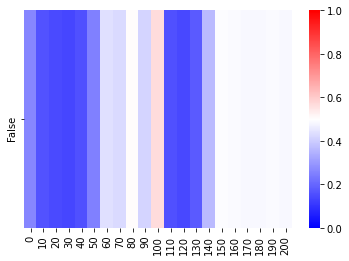

Mean result: 


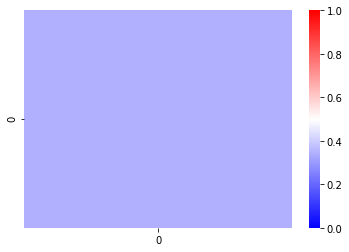

In [ ]:
result_data = np.squeeze(predictions)
visualize_data = [result_data]
xSigns = [10*i for i in range(len(result_data))]
ySigns = ["False"]
ax = sns.heatmap(visualize_data, vmin=0, vmax=1, cmap="bwr", xticklabels=xSigns, yticklabels=ySigns)
print('Results by each 10 seconds: ')
plt.show()
ax = sns.heatmap([[visualize_data[0].mean()]], vmin=0, vmax=1, cmap="bwr")
print('Mean result: ')
plt.show()

## Оценка модели

In [ ]:
from dataset.manager.data_manager import DataManager

DATASET_TF_RECORDS_PATH = "/content/drive/MyDrive/deception_dataset/tmp/deception_dataset_features"
from dataset.preprocessor.multimodal_dataset_features_processor import MultimodalDatasetFeaturesProcessor
data_manager = DataManager(
            tf_record_path=DATASET_TF_RECORDS_PATH,
            batch_size=4)

Dataset files: ['/content/drive/MyDrive/deception_dataset/tmp/deception_dataset_features/deception_dataset_features-1.tfrecords', '/content/drive/MyDrive/deception_dataset/tmp/deception_dataset_features/deception_dataset_features-10.tfrecords', '/content/drive/MyDrive/deception_dataset/tmp/deception_dataset_features/deception_dataset_features-11.tfrecords', '/content/drive/MyDrive/deception_dataset/tmp/deception_dataset_features/deception_dataset_features-12.tfrecords', '/content/drive/MyDrive/deception_dataset/tmp/deception_dataset_features/deception_dataset_features-13.tfrecords', '/content/drive/MyDrive/deception_dataset/tmp/deception_dataset_features/deception_dataset_features-14.tfrecords', '/content/drive/MyDrive/deception_dataset/tmp/deception_dataset_features/deception_dataset_features-15.tfrecords', '/content/drive/MyDrive/deception_dataset/tmp/deception_dataset_features/deception_dataset_features-16.tfrecords', '/content/drive/MyDrive/deception_dataset/tmp/deception_dataset_f

In [ ]:
valid = data_manager.build_validation_dataset( MultimodalDatasetFeaturesProcessor(modalities_list=modalities))

valid_numpy_dataset_y = []
for x in valid.as_numpy_iterator():
    valid_numpy_dataset_y.extend(x[1])
valid_numpy_dataset_y = np.asarray(valid_numpy_dataset_y)
print(valid_numpy_dataset_y.shape)

(160, 1)


In [ ]:
cnn_predicted = model.get_test_model().predict(valid)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy
from sklearn.externals._arff import xrange
from sklearn.metrics import roc_curve, confusion_matrix


def plot_binary_classification(y_test, predicted, predicted_prob, name):
    predicted = numpy.around(predicted, 0)
    if predicted_prob is not None:
        # Show ROC curve
        fpr, tpr, threshold = roc_curve(y_test, predicted_prob)
        print("rates")
        print(fpr)
        print(tpr)
        print("ROC threshold")
        print(threshold)
        plt.plot(fpr, tpr)
        plt.title('ROC curve: ' + name)
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.xlim(0, )
        plt.ylim(0, )
        plt.show()

    # Show confusion matrix
    cm = confusion_matrix(y_test, predicted)
    print(cm)
    plt.figure(figsize=(7, 7))
    plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
    plt.title('Confusion matrix: ' + name, size=10)
    plt.colorbar()
    tick_marks = numpy.arange(2)
    plt.xticks(tick_marks, ["Deception", "Truth"], size=10)
    plt.yticks(tick_marks, ["Deception", "Truth"], size=10)
    plt.tight_layout()
    plt.ylabel('Actual label', size=10)
    plt.xlabel('Predicted label', size=10)
    width, height = cm.shape
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x),
                         horizontalalignment='center',
                         verticalalignment='center',
                         size=20)
    plt.show()

rates
[0.         0.         0.         0.01234568 0.01234568 0.02469136
 0.02469136 0.03703704 0.03703704 0.09876543 0.09876543 0.11111111
 0.11111111 0.13580247 0.13580247 0.14814815 0.14814815 0.19753086
 0.19753086 0.24691358 0.24691358 0.28395062 0.28395062 1.        ]
[0.         0.01265823 0.73417722 0.73417722 0.81012658 0.81012658
 0.82278481 0.82278481 0.84810127 0.84810127 0.87341772 0.87341772
 0.88607595 0.88607595 0.92405063 0.92405063 0.93670886 0.93670886
 0.94936709 0.94936709 0.98734177 0.98734177 1.         1.        ]
ROC threshold
[1.9393094  0.9393094  0.8878148  0.87950325 0.85598654 0.8525013
 0.8513418  0.84532297 0.820944   0.64267826 0.5438639  0.5331279
 0.501048   0.49058792 0.48932466 0.4892266  0.4887392  0.4883536
 0.48824537 0.4877574  0.48762357 0.48707113 0.48705366 0.05564524]


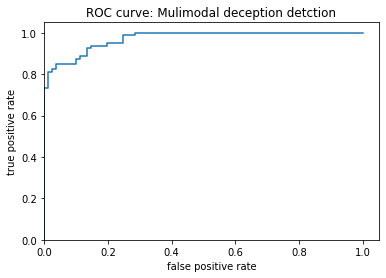

[[72  9]
 [ 9 70]]


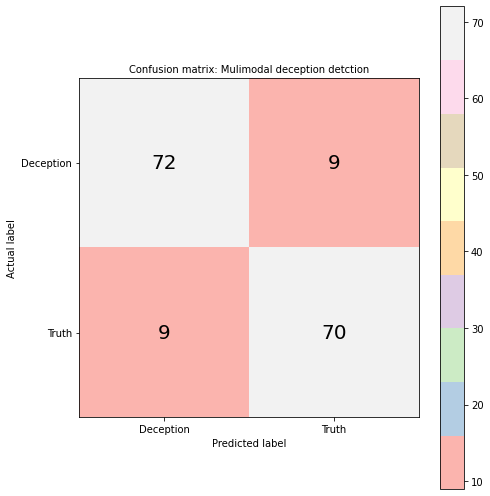

In [ ]:
plot_binary_classification( valid_numpy_dataset_y, cnn_predicted,
                                                 cnn_predicted,
                                                 "Mulimodal deception detction")